In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import shap
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [2]:
df = pd.read_csv('./sorghum_3mers.csv')
df.head(2)

,chromosome,window_start,window_end,rec,AAA,AAC,AAG,AAT,ACA,ACC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,chr1,1,100000,0.0,2891,1560,2137,2244,1824,1364,...,913,1683,1888,1569,1705,1774,1685,1620,2126,2670
1,chr1,100001,200000,0.0,2781,1575,1817,2133,1961,1372,...,837,1843,1836,1813,1542,2001,1680,1746,2094,2828


# Recombination smoothing

In [3]:
df = df
df['srec'] = 0

for i in  range(1, len(df)):
    if df.loc[i-1,'chromosome'] == df.loc[i,'chromosome']:
        df.loc[i, 'srec'] = df.loc[i-1, 'rec']*0.1 + df.loc[i-1, 'srec']*0.9

In [4]:
df = df.dropna()

# Chromosome Split

Testing data with chromosome info

In [5]:
# Dataframes with chrs info
chr1 = df[df["chromosome"] == "chr1"]
chr2 = df[df["chromosome"] == "chr2"]
chr3 = df[df["chromosome"] == "chr3"]
chr4 = df[df["chromosome"] == "chr4"]
chr5 = df[df["chromosome"] == "chr5"]
chr6 = df[df["chromosome"] == "chr6"]
chr7 = df[df["chromosome"] == "chr7"]
chr8 = df[df["chromosome"] == "chr8"]
chr9 = df[df["chromosome"] == "chr9"]
chr10 = df[df["chromosome"] == "chr10"]

Training data without the chromosome to be predicted

In [6]:
# Dataframes with the remaining chrs info
achr1 = df[df["chromosome"] != "chr1"]
achr2 = df[df["chromosome"] != "chr2"]
achr3 = df[df["chromosome"] != "chr3"]
achr4 = df[df["chromosome"] != "chr4"]
achr5 = df[df["chromosome"] != "chr5"]
achr6 = df[df["chromosome"] != "chr6"]
achr7 = df[df["chromosome"] != "chr7"]
achr8 = df[df["chromosome"] != "chr8"]
achr9 = df[df["chromosome"] != "chr9"]
achr10 = df[df["chromosome"] != "chr10"]

# Model Predictions

Predictions on each chromosome, using the information from the remaining chromosomes as a training set. For example, if chromosome 1 is to be predicted, the training set will be composed of chromosomes 2, 3, 4.... etc. 

Correlation: 0.7096342714426871
Coefficient of Determination: 0.5013045741822182
Mean Squared Error: 0.02640766378567138


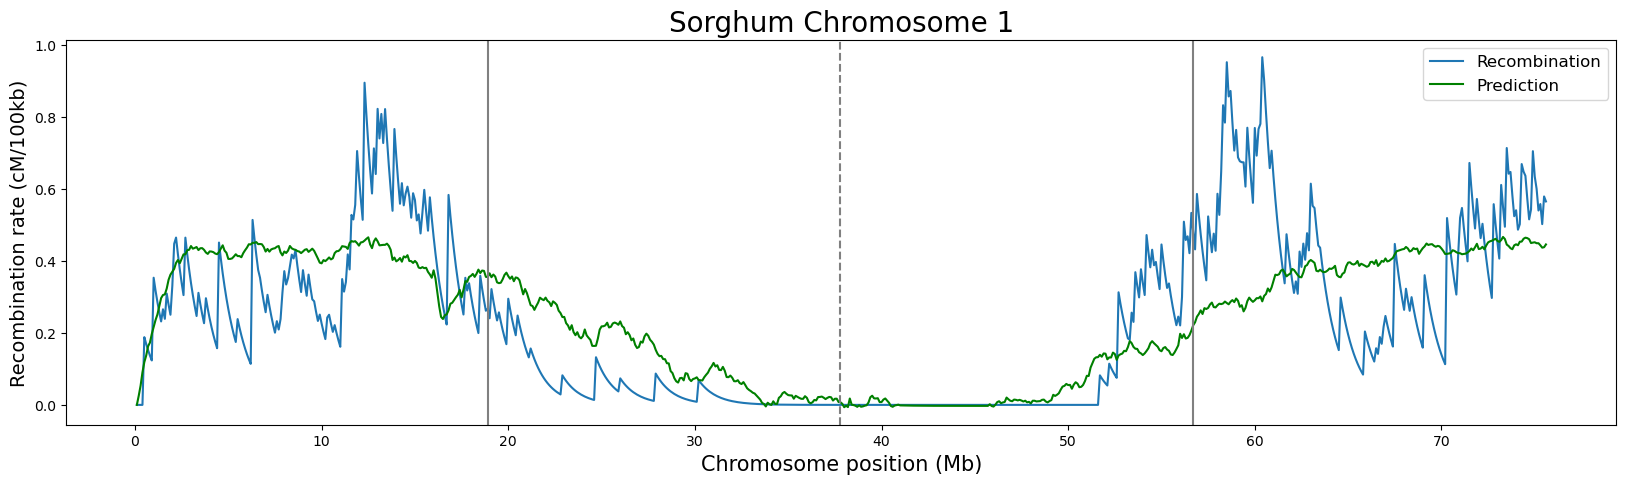

In [7]:
# TRAINING MODEL
X = achr1.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr1.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr1.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr1 = model_spreds      
    
#PARAMETERS
corr_chr1 = pearsonr(chr1.srec, pchr1)
r2_chr1 = r2_score(chr1.srec, pchr1)
mse_chr1 = mean_squared_error(chr1.srec, pchr1)
print('Correlation:', corr_chr1[0])
print('Coefficient of Determination:', r2_chr1)
print('Mean Squared Error:', mse_chr1)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr1)*0.25)
c_q2 = int(len(chr1)*0.50)
c_q3 = int(len(chr1)*0.75)

rq1 = chr1['srec'].iloc[0:c_q1]
rq2 = chr1['srec'].iloc[c_q1:c_q2]
rq3 = chr1['srec'].iloc[c_q2:c_q3]
rq4 = chr1['srec'].iloc[c_q3:int(len(chr1))]

pq1 = pchr1[0:c_q1]
pq2 = pchr1[c_q1:c_q2]
pq3 = pchr1[c_q2:c_q3]
pq4 = pchr1[c_q3:int(len(chr1))]

corr_chr1_q1 = pearsonr(rq1, pq1)
corr_chr1_q2 = pearsonr(rq2, pq2)
corr_chr1_q3 = pearsonr(rq3, pq3)
corr_chr1_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr1. window_end,chr1.srec, label='Recombination')
ax.plot(chr1. window_end,pchr1, label = 'Prediction',  color ='green')
plt.title('Sorghum Chromosome 1',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr1["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.8866848731771613
Coefficient of Determination: 0.7541544751953233
Mean Squared Error: 0.013910069899904835


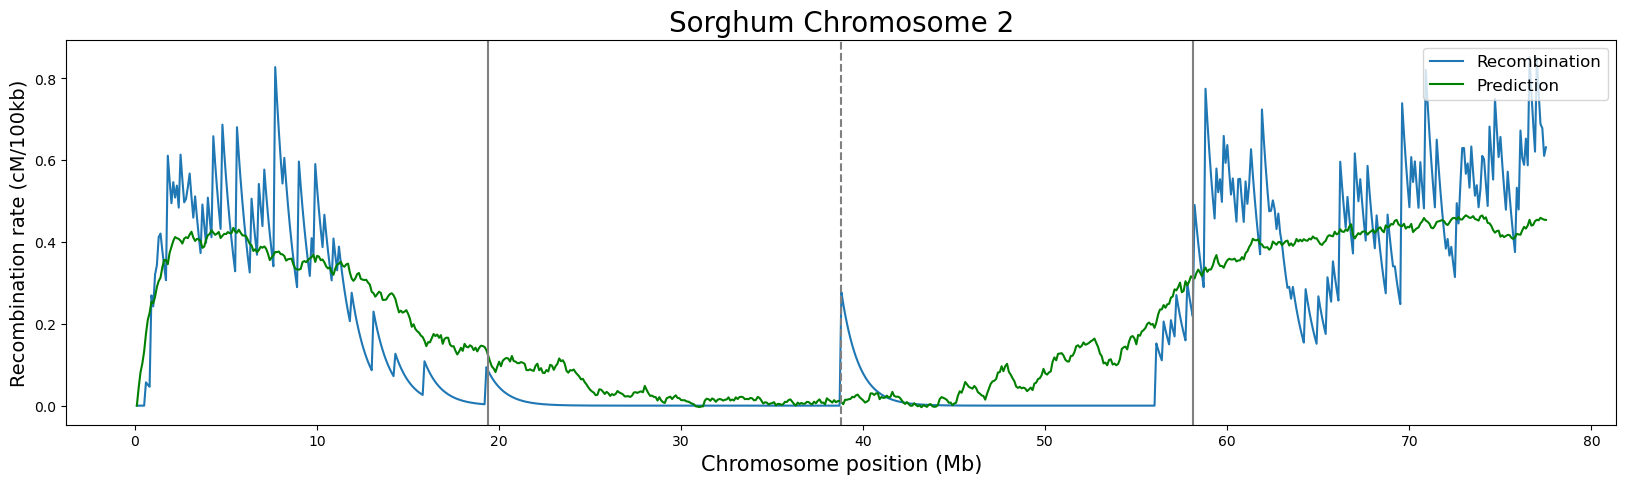

In [8]:
# TRAINING MODEL
X = achr2.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr2.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr2.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr2 = model_spreds      
    
#PARAMETERS
corr_chr2 = pearsonr(chr2.srec, pchr2)
r2_chr2 = r2_score(chr2.srec, pchr2)
mse_chr2 = mean_squared_error(chr2.srec, pchr2)
print('Correlation:', corr_chr2[0])
print('Coefficient of Determination:', r2_chr2)
print('Mean Squared Error:', mse_chr2)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr2)*0.25)
c_q2 = int(len(chr2)*0.50)
c_q3 = int(len(chr2)*0.75)

rq1 = chr2['srec'].iloc[0:c_q1]
rq2 = chr2['srec'].iloc[c_q1:c_q2]
rq3 = chr2['srec'].iloc[c_q2:c_q3]
rq4 = chr2['srec'].iloc[c_q3:int(len(chr2))]

pq1 = pchr2[0:c_q1]
pq2 = pchr2[c_q1:c_q2]
pq3 = pchr2[c_q2:c_q3]
pq4 = pchr2[c_q3:int(len(chr2))]

corr_chr2_q1 = pearsonr(rq1, pq1)
corr_chr2_q2 = pearsonr(rq2, pq2)
corr_chr2_q3 = pearsonr(rq3, pq3)
corr_chr2_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr2. window_end,chr2.srec, label='Recombination')
ax.plot(chr2. window_end,pchr2, label = 'Prediction',  color ='green')
plt.title('Sorghum Chromosome 2',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr2["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.8323539491521499
Coefficient of Determination: 0.5876672028813437
Mean Squared Error: 0.016073339942322417


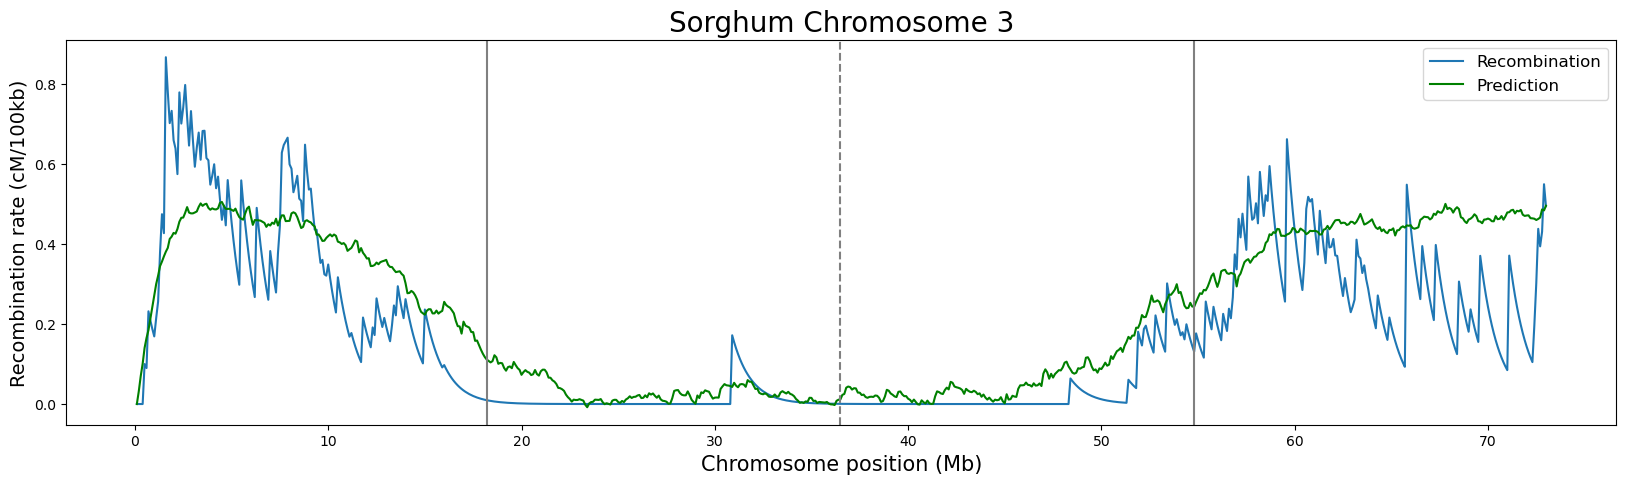

In [9]:
# TRAINING MODEL
X = achr3.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr3.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr3.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr3 = model_spreds      
    
#PARAMETERS
corr_chr3 = pearsonr(chr3.srec, pchr3)
r2_chr3 = r2_score(chr3.srec, pchr3)
mse_chr3 = mean_squared_error(chr3.srec, pchr3)
print('Correlation:', corr_chr3[0])
print('Coefficient of Determination:', r2_chr3)
print('Mean Squared Error:', mse_chr3)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr3)*0.25)
c_q2 = int(len(chr3)*0.50)
c_q3 = int(len(chr3)*0.75)

rq1 = chr3['srec'].iloc[0:c_q1]
rq2 = chr3['srec'].iloc[c_q1:c_q2]
rq3 = chr3['srec'].iloc[c_q2:c_q3]
rq4 = chr3['srec'].iloc[c_q3:int(len(chr3))]

pq1 = pchr3[0:c_q1]
pq2 = pchr3[c_q1:c_q2]
pq3 = pchr3[c_q2:c_q3]
pq4 = pchr3[c_q3:int(len(chr3))]

corr_chr3_q1 = pearsonr(rq1, pq1)
corr_chr3_q2 = pearsonr(rq2, pq2)
corr_chr3_q3 = pearsonr(rq3, pq3)
corr_chr3_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr3. window_end,chr3.srec, label='Recombination')
ax.plot(chr3. window_end,pchr3, label = 'Prediction',  color ='green')
plt.title('Sorghum Chromosome 3',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr3["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.8019187389083413
Coefficient of Determination: 0.6254772382063377
Mean Squared Error: 0.02069953186231793


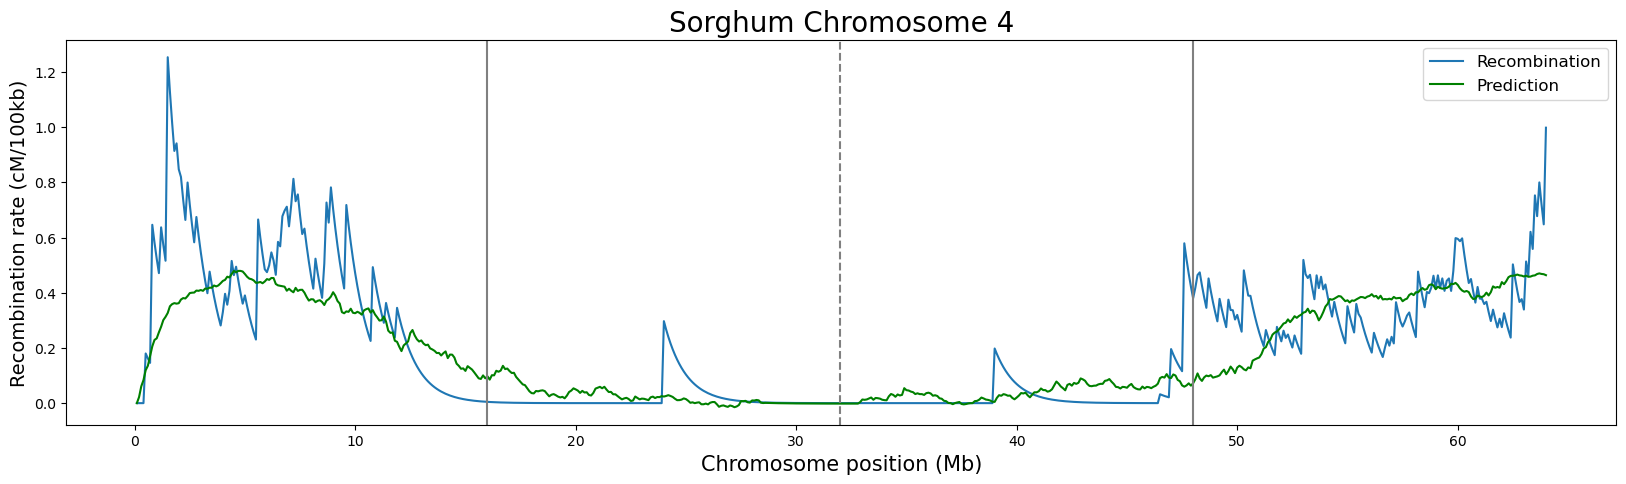

In [10]:
# TRAINING MODEL
X = achr4.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr4.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr4.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr4 = model_spreds      
    
#PARAMETERS
corr_chr4 = pearsonr(chr4.srec, pchr4)
r2_chr4 = r2_score(chr4.srec, pchr4)
mse_chr4 = mean_squared_error(chr4.srec, pchr4)
print('Correlation:', corr_chr4[0])
print('Coefficient of Determination:', r2_chr4)
print('Mean Squared Error:', mse_chr4)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr4)*0.25)
c_q2 = int(len(chr4)*0.50)
c_q3 = int(len(chr4)*0.75)

rq1 = chr4['srec'].iloc[0:c_q1]
rq2 = chr4['srec'].iloc[c_q1:c_q2]
rq3 = chr4['srec'].iloc[c_q2:c_q3]
rq4 = chr4['srec'].iloc[c_q3:int(len(chr4))]

pq1 = pchr4[0:c_q1]
pq2 = pchr4[c_q1:c_q2]
pq3 = pchr4[c_q2:c_q3]
pq4 = pchr4[c_q3:int(len(chr4))]

corr_chr4_q1 = pearsonr(rq1, pq1)
corr_chr4_q2 = pearsonr(rq2, pq2)
corr_chr4_q3 = pearsonr(rq3, pq3)
corr_chr4_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr4. window_end,chr4.srec, label='Recombination')
ax.plot(chr4. window_end,pchr4, label = 'Prediction',  color ='green')
plt.title('Sorghum Chromosome 4',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr4["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.8801905243402413
Coefficient of Determination: 0.6544223282156226
Mean Squared Error: 0.020827547735548763


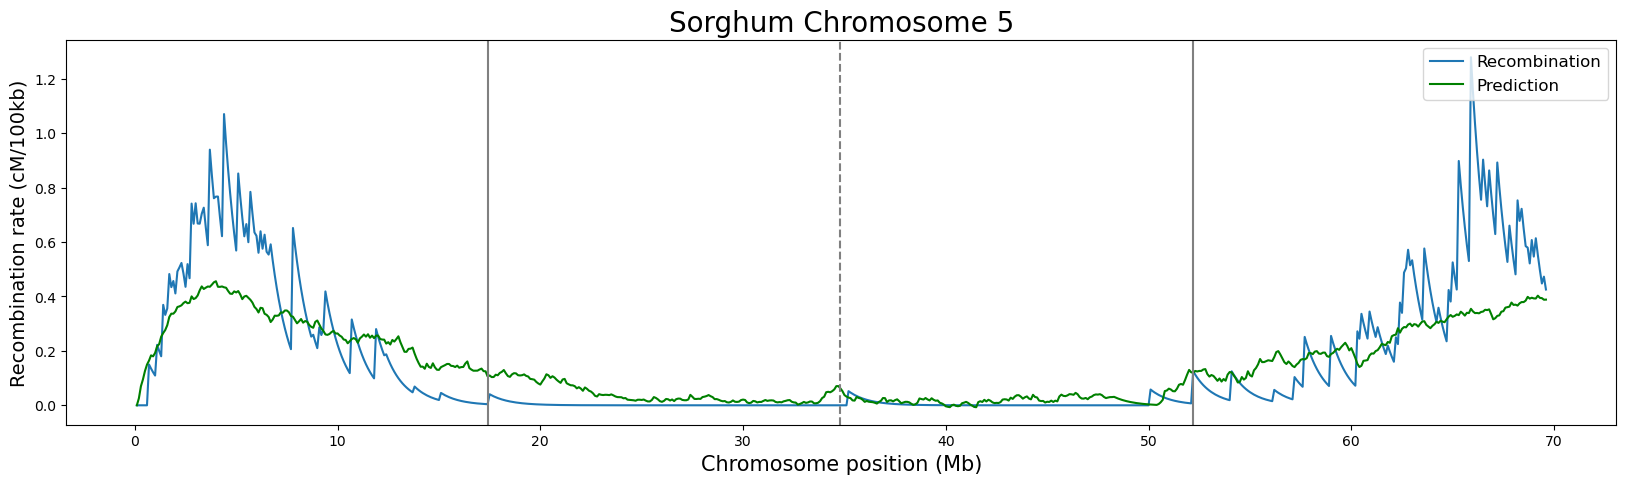

In [11]:
# TRAINING MODEL
X = achr5.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr5.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr5.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr5 = model_spreds      
    
#PARAMETERS
corr_chr5 = pearsonr(chr5.srec, pchr5)
r2_chr5 = r2_score(chr5.srec, pchr5)
mse_chr5 = mean_squared_error(chr5.srec, pchr5)
print('Correlation:', corr_chr5[0])
print('Coefficient of Determination:', r2_chr5)
print('Mean Squared Error:', mse_chr5)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr5)*0.25)
c_q2 = int(len(chr5)*0.50)
c_q3 = int(len(chr5)*0.75)

rq1 = chr5['srec'].iloc[0:c_q1]
rq2 = chr5['srec'].iloc[c_q1:c_q2]
rq3 = chr5['srec'].iloc[c_q2:c_q3]
rq4 = chr5['srec'].iloc[c_q3:int(len(chr5))]

pq1 = pchr5[0:c_q1]
pq2 = pchr5[c_q1:c_q2]
pq3 = pchr5[c_q2:c_q3]
pq4 = pchr5[c_q3:int(len(chr5))]

corr_chr5_q1 = pearsonr(rq1, pq1)
corr_chr5_q2 = pearsonr(rq2, pq2)
corr_chr5_q3 = pearsonr(rq3, pq3)
corr_chr5_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr5. window_end,chr5.srec, label='Recombination')
ax.plot(chr5. window_end,pchr5, label = 'Prediction',  color ='green')
plt.title('Sorghum Chromosome 5',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr5["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.8566804769918095
Coefficient of Determination: 0.6958689839853744
Mean Squared Error: 0.014810850764106537


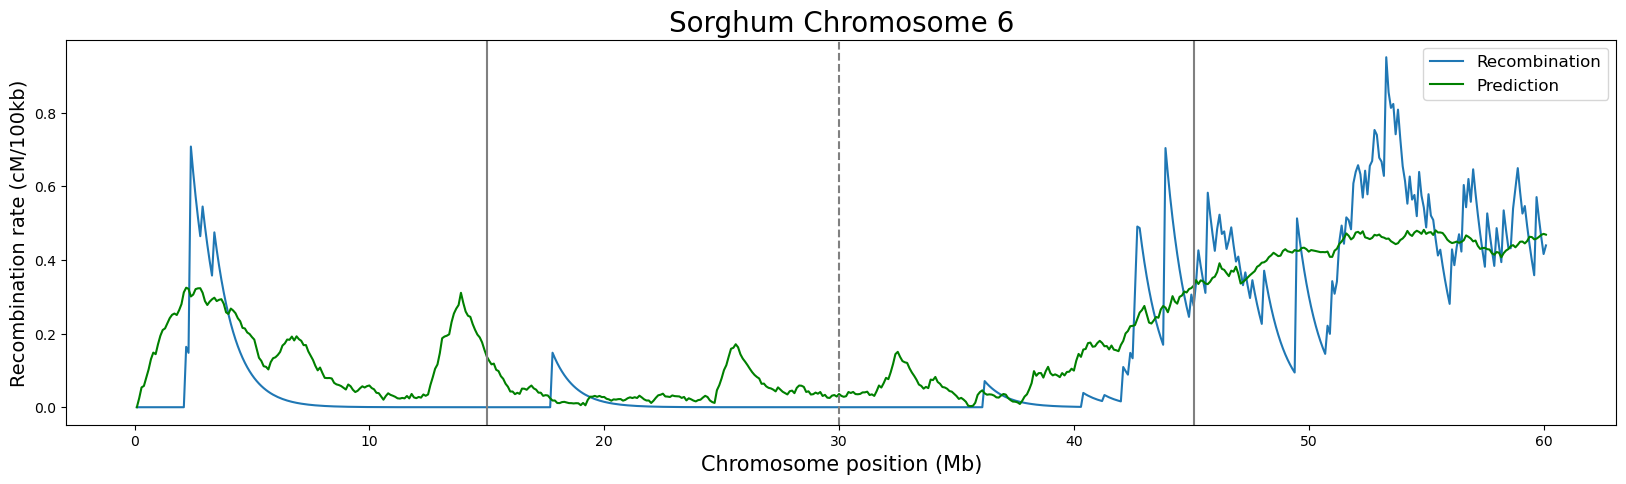

In [12]:
# TRAINING MODEL
X = achr6.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr6.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr6.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr6 = model_spreds      
    
#PARAMETERS
corr_chr6 = pearsonr(chr6.srec, pchr6)
r2_chr6 = r2_score(chr6.srec, pchr6)
mse_chr6 = mean_squared_error(chr6.srec, pchr6)
print('Correlation:', corr_chr6[0])
print('Coefficient of Determination:', r2_chr6)
print('Mean Squared Error:', mse_chr6)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr6)*0.25)
c_q2 = int(len(chr6)*0.50)
c_q3 = int(len(chr6)*0.75)

rq1 = chr6['srec'].iloc[0:c_q1]
rq2 = chr6['srec'].iloc[c_q1:c_q2]
rq3 = chr6['srec'].iloc[c_q2:c_q3]
rq4 = chr6['srec'].iloc[c_q3:int(len(chr6))]

pq1 = pchr6[0:c_q1]
pq2 = pchr6[c_q1:c_q2]
pq3 = pchr6[c_q2:c_q3]
pq4 = pchr6[c_q3:int(len(chr6))]

corr_chr6_q1 = pearsonr(rq1, pq1)
corr_chr6_q2 = pearsonr(rq2, pq2)
corr_chr6_q3 = pearsonr(rq3, pq3)
corr_chr6_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr6. window_end,chr6.srec, label='Recombination')
ax.plot(chr6. window_end,pchr6, label = 'Prediction',  color ='green')
plt.title('Sorghum Chromosome 6',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr6["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.9122247220242414
Coefficient of Determination: 0.6507670744332444
Mean Squared Error: 0.022753263950456345


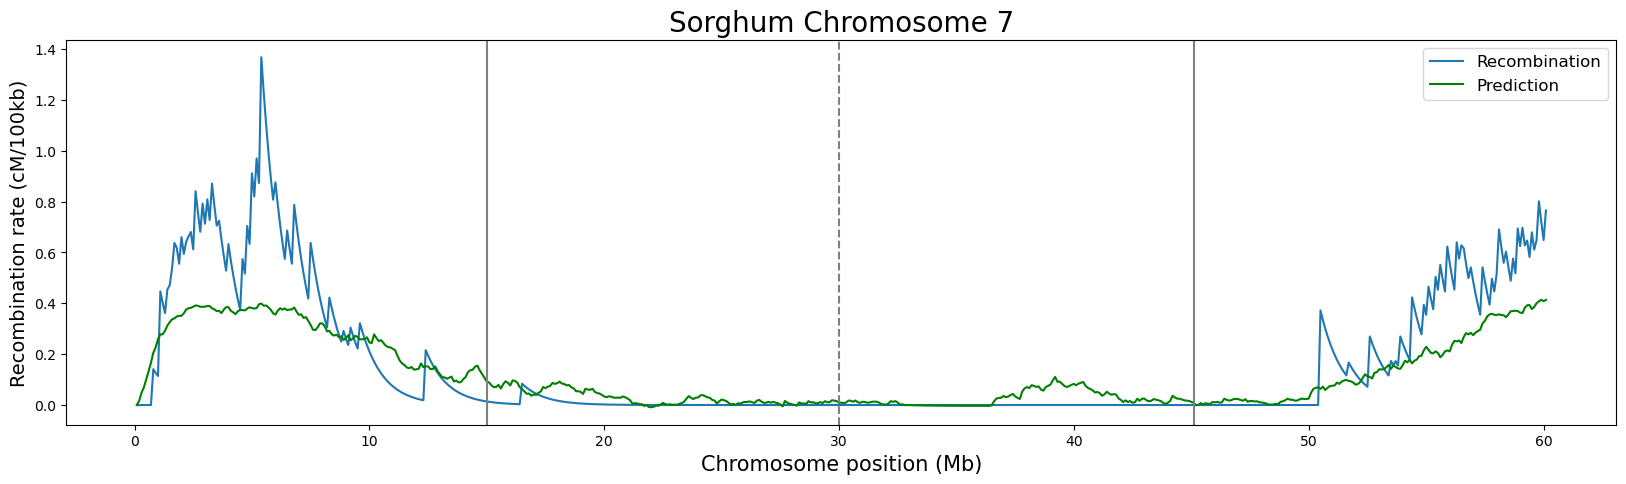

In [13]:
# TRAINING MODEL
X = achr7.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr7.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr7.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr7 = model_spreds      
    
#PARAMETERS
corr_chr7 = pearsonr(chr7.srec, pchr7)
r2_chr7 = r2_score(chr7.srec, pchr7)
mse_chr7 = mean_squared_error(chr7.srec, pchr7)
print('Correlation:', corr_chr7[0])
print('Coefficient of Determination:', r2_chr7)
print('Mean Squared Error:', mse_chr7)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr7)*0.25)
c_q2 = int(len(chr7)*0.50)
c_q3 = int(len(chr7)*0.75)

rq1 = chr7['srec'].iloc[0:c_q1]
rq2 = chr7['srec'].iloc[c_q1:c_q2]
rq3 = chr7['srec'].iloc[c_q2:c_q3]
rq4 = chr7['srec'].iloc[c_q3:int(len(chr7))]

pq1 = pchr7[0:c_q1]
pq2 = pchr7[c_q1:c_q2]
pq3 = pchr7[c_q2:c_q3]
pq4 = pchr7[c_q3:int(len(chr7))]

corr_chr7_q1 = pearsonr(rq1, pq1)
corr_chr7_q2 = pearsonr(rq2, pq2)
corr_chr7_q3 = pearsonr(rq3, pq3)
corr_chr7_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr7. window_end,chr7.srec, label='Recombination')
ax.plot(chr7. window_end,pchr7, label = 'Prediction',  color ='green')
plt.title('Sorghum Chromosome 7',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr7["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.912610941386316
Coefficient of Determination: 0.5757549028044888
Mean Squared Error: 0.03882754892846773


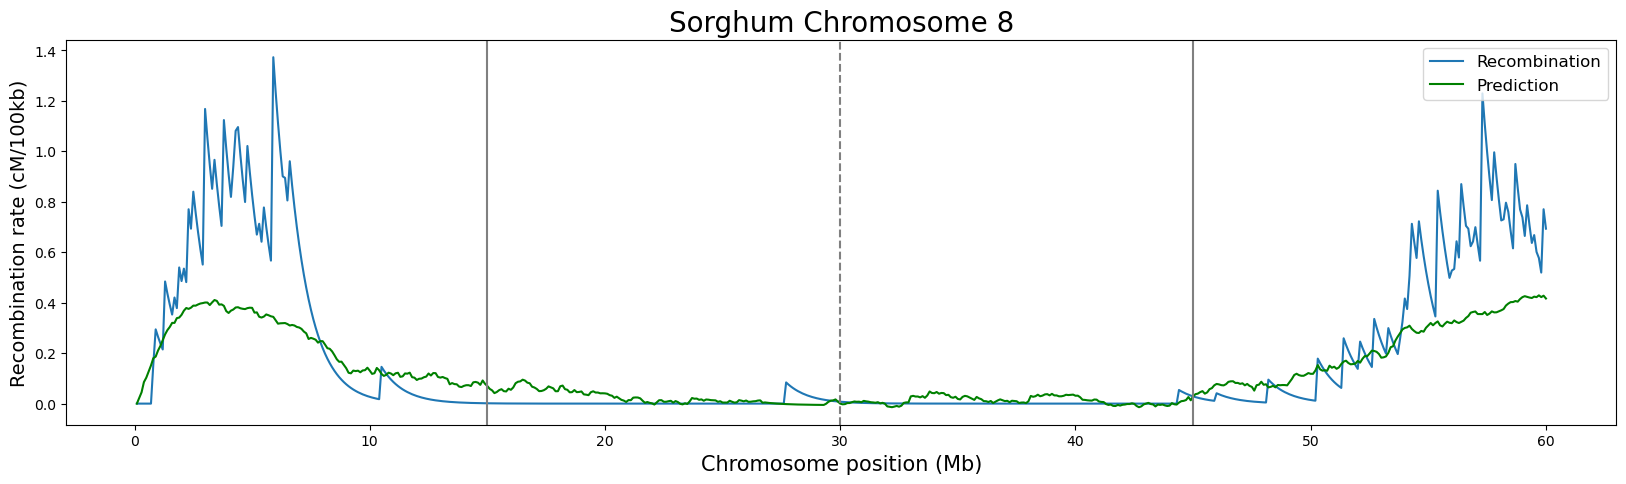

In [14]:
# TRAINING MODEL
X = achr8.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr8.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr8.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr8 = model_spreds      
    
#PARAMETERS
corr_chr8 = pearsonr(chr8.srec, pchr8)
r2_chr8 = r2_score(chr8.srec, pchr8)
mse_chr8 = mean_squared_error(chr8.srec, pchr8)
print('Correlation:', corr_chr8[0])
print('Coefficient of Determination:', r2_chr8)
print('Mean Squared Error:', mse_chr8)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr8)*0.25)
c_q2 = int(len(chr8)*0.50)
c_q3 = int(len(chr8)*0.75)

rq1 = chr8['srec'].iloc[0:c_q1]
rq2 = chr8['srec'].iloc[c_q1:c_q2]
rq3 = chr8['srec'].iloc[c_q2:c_q3]
rq4 = chr8['srec'].iloc[c_q3:int(len(chr8))]

pq1 = pchr8[0:c_q1]
pq2 = pchr8[c_q1:c_q2]
pq3 = pchr8[c_q2:c_q3]
pq4 = pchr8[c_q3:int(len(chr8))]

corr_chr8_q1 = pearsonr(rq1, pq1)
corr_chr8_q2 = pearsonr(rq2, pq2)
corr_chr8_q3 = pearsonr(rq3, pq3)
corr_chr8_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr8. window_end,chr8.srec, label='Recombination')
ax.plot(chr8. window_end,pchr8, label = 'Prediction',  color ='green')
plt.title('Sorghum Chromosome 8',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr8["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.8230376856681407
Coefficient of Determination: 0.5588267985639497
Mean Squared Error: 0.027425877483005942


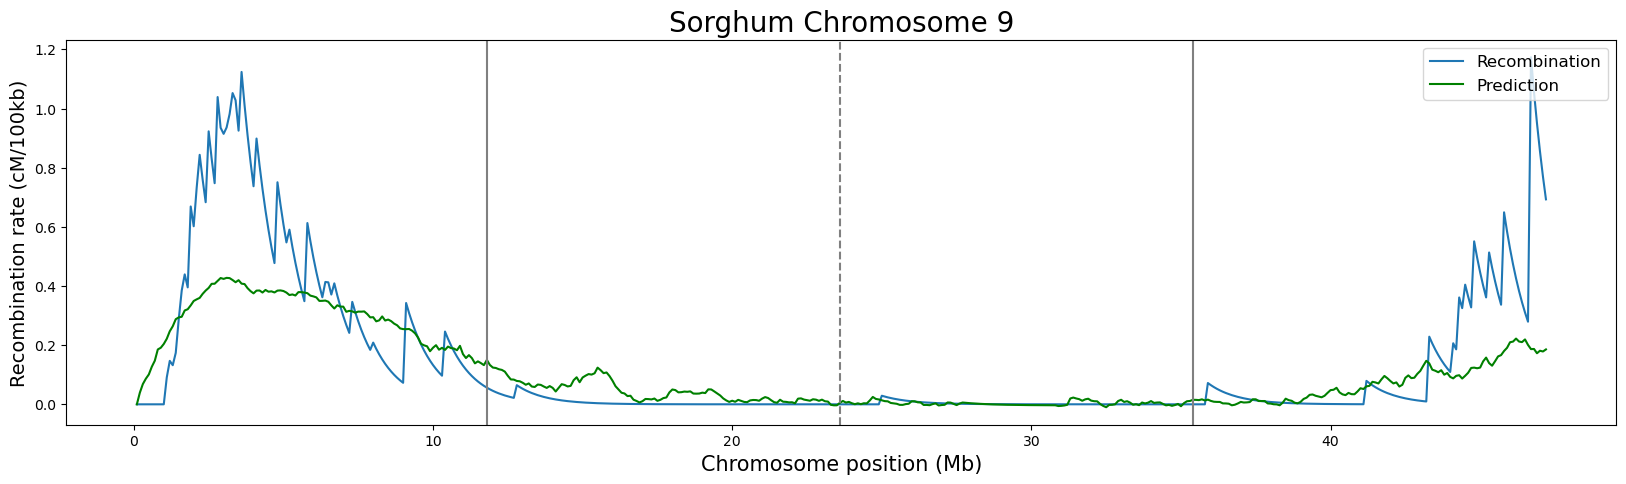

In [15]:
# TRAINING MODEL
X = achr9.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr9.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr9.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr9 = model_spreds      
    
#PARAMETERS
corr_chr9 = pearsonr(chr9.srec, pchr9)
r2_chr9 = r2_score(chr9.srec, pchr9)
mse_chr9 = mean_squared_error(chr9.srec, pchr9)
print('Correlation:', corr_chr9[0])
print('Coefficient of Determination:', r2_chr9)
print('Mean Squared Error:', mse_chr9)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr9)*0.25)
c_q2 = int(len(chr9)*0.50)
c_q3 = int(len(chr9)*0.75)

rq1 = chr9['srec'].iloc[0:c_q1]
rq2 = chr9['srec'].iloc[c_q1:c_q2]
rq3 = chr9['srec'].iloc[c_q2:c_q3]
rq4 = chr9['srec'].iloc[c_q3:int(len(chr9))]

pq1 = pchr9[0:c_q1]
pq2 = pchr9[c_q1:c_q2]
pq3 = pchr9[c_q2:c_q3]
pq4 = pchr9[c_q3:int(len(chr9))]

corr_chr9_q1 = pearsonr(rq1, pq1)
corr_chr9_q2 = pearsonr(rq2, pq2)
corr_chr9_q3 = pearsonr(rq3, pq3)
corr_chr9_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr9. window_end,chr9.srec, label='Recombination')
ax.plot(chr9. window_end,pchr9, label = 'Prediction',  color ='green')
plt.title('Sorghum Chromosome 9',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr9["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

Correlation: 0.8495569810673053
Coefficient of Determination: 0.6094079361983381
Mean Squared Error: 0.03099706865664542


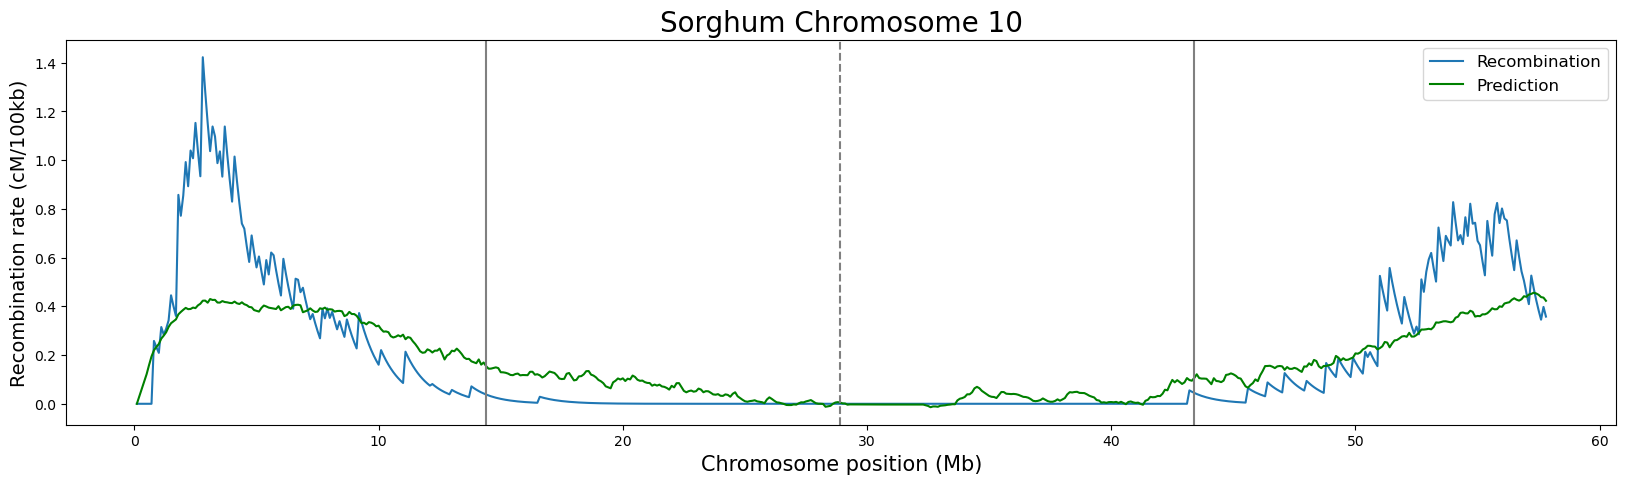

In [16]:
# TRAINING MODEL
X = achr10.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = achr10.srec
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1) 

model = LinearRegression()
model.fit(X_train, y_train)
model_preds = model.predict(chr10.drop(['chromosome','window_start','window_end','rec','srec'], axis=1))

#SMOOTHING
model_spreds= np.zeros(len(model_preds))

for i in  range(1, len(model_preds)): 
    model_spreds[i] = model_preds[i-1]*0.1 + model_spreds[i-1]*0.9

pchr10 = model_spreds      
    
#PARAMETERS
corr_chr10 = pearsonr(chr10.srec, pchr10)
r2_chr10 = r2_score(chr10.srec, pchr10)
mse_chr10 = mean_squared_error(chr10.srec, pchr10)
print('Correlation:', corr_chr10[0])
print('Coefficient of Determination:', r2_chr10)
print('Mean Squared Error:', mse_chr10)

#CORRELATIONS BY QUARTILES
c_q1 = int(len(chr10)*0.25)
c_q2 = int(len(chr10)*0.50)
c_q3 = int(len(chr10)*0.75)

rq1 = chr10['srec'].iloc[0:c_q1]
rq2 = chr10['srec'].iloc[c_q1:c_q2]
rq3 = chr10['srec'].iloc[c_q2:c_q3]
rq4 = chr10['srec'].iloc[c_q3:int(len(chr10))]

pq1 = pchr10[0:c_q1]
pq2 = pchr10[c_q1:c_q2]
pq3 = pchr10[c_q2:c_q3]
pq4 = pchr10[c_q3:int(len(chr10))]

corr_chr10_q1 = pearsonr(rq1, pq1)
corr_chr10_q2 = pearsonr(rq2, pq2)
corr_chr10_q3 = pearsonr(rq3, pq3)
corr_chr10_q4 = pearsonr(rq4, pq4)

# PLOTTING RESULTS
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(chr10. window_end,chr10.srec, label='Recombination')
ax.plot(chr10. window_end,pchr10, label = 'Prediction',  color ='green')
plt.title('Sorghum Chromosome 10',fontsize=20) 
ax.set_xlabel('Chromosome position (Mb)', fontsize=15)
ax.set_ylabel('Recombination rate (cM/100kb)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ticks = ax.get_xticks()/1000000
ax.set_xticklabels(ticks.astype(int))

chr_len = chr10["window_end"].iloc[-1]
q1 =round(chr_len * 0.25 / 100000) * 100000
q2 =round(chr_len* 0.50 / 100000) * 100000
q3 =round(chr_len * 0.75 / 100000) * 100000

plt.axvline(x=q1, color='gray', linestyle='-')
plt.axvline(x=q2, color='gray', linestyle='--')
plt.axvline(x=q3, color='gray', linestyle='-')
plt.show()

# Compilation of the prediction results

In [17]:
corr = pd.DataFrame({'corr':[corr_chr1[0], corr_chr2[0], corr_chr3[0], corr_chr4[0], corr_chr5[0], corr_chr6[0], corr_chr7[0], corr_chr8[0], corr_chr9[0], corr_chr10[0]]})
r2 = pd.DataFrame({'R^2':[r2_chr1, r2_chr2, r2_chr3, r2_chr4, r2_chr5, r2_chr6, r2_chr7, r2_chr8, r2_chr9, r2_chr10]})
mse = pd.DataFrame({'MSE':[mse_chr1, mse_chr2, mse_chr3, mse_chr4, mse_chr5, mse_chr6, mse_chr7, mse_chr8, mse_chr9, mse_chr10]})
index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10']})
results = pd.concat([index, corr, r2, mse], axis=1)
results

,chr,corr,R^2,MSE
0,chr1,0.709634,0.501305,0.026408
1,chr2,0.886685,0.754154,0.013910
2,chr3,0.832354,0.587667,0.016073
3,chr4,0.801919,0.625477,0.020700
4,chr5,0.880191,0.654422,0.020828
5,chr6,0.856680,0.695869,0.014811
6,chr7,0.912225,0.650767,0.022753
7,chr8,0.912611,0.575755,0.038828
8,chr9,0.823038,0.558827,0.027426
9,chr10,0.849557,0.609408,0.030997


In [18]:
results.describe()

,corr,R^2,MSE
count,10.000000,10.000000,10.000000
mean,0.846489,0.621365,0.023273
std,0.060575,0.072144,0.007836
min,0.709634,0.501305,0.013910
25%,0.825367,0.578733,0.017230
50%,0.853119,0.617443,0.021790
75%,0.885061,0.653509,0.027171
max,0.912611,0.754154,0.038828


Correlation between model predictions and recombination rates by quartiles

In [19]:
corr_q1 = pd.DataFrame({'Q1':[corr_chr1_q1[0], corr_chr2_q1[0], corr_chr3_q1[0], corr_chr4_q1[0], corr_chr5_q1[0], corr_chr6_q1[0], corr_chr7_q1[0], corr_chr8_q1[0], corr_chr9_q1[0], corr_chr10_q1[0]]})
corr_q2 = pd.DataFrame({'Q2':[corr_chr1_q2[0], corr_chr2_q2[0], corr_chr3_q2[0], corr_chr4_q2[0], corr_chr5_q2[0], corr_chr6_q2[0], corr_chr7_q2[0], corr_chr8_q2[0], corr_chr9_q2[0], corr_chr10_q2[0]]})
corr_q3 = pd.DataFrame({'Q3':[corr_chr1_q3[0], corr_chr2_q3[0], corr_chr3_q3[0], corr_chr4_q3[0], corr_chr5_q3[0], corr_chr6_q3[0], corr_chr7_q3[0], corr_chr8_q3[0], corr_chr9_q3[0], corr_chr10_q3[0]]})
corr_q4 = pd.DataFrame({'Q4':[corr_chr1_q4[0], corr_chr2_q4[0], corr_chr3_q4[0], corr_chr4_q4[0], corr_chr5_q4[0], corr_chr6_q4[0], corr_chr7_q4[0], corr_chr8_q4[0], corr_chr9_q4[0], corr_chr10_q4[0]]})

index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10']})
q_corr = pd.concat([index, corr_q1, corr_q2, corr_q3, corr_q4], axis=1)
q_corr_styled = q_corr.style.background_gradient(cmap="PRGn", vmin=-1, vmax=1)
q_corr_styled.set_table_styles([{'selector': 'th',
                                'props': [('text-align', 'center')]}])
q_corr_styled

,chr,Q1,Q2,Q3,Q4
0,chr1,0.391331,0.816071,0.859195,-0.374463
1,chr2,0.887400,0.571315,0.468810,0.140470
2,chr3,0.801730,0.141880,0.897731,-0.023164
3,chr4,0.700869,-0.102111,0.214428,0.235793
4,chr5,0.920223,0.637411,0.237793,0.838916
5,chr6,0.599713,-0.315910,0.778204,0.425770
6,chr7,0.884689,0.422162,-0.203884,0.934929
7,chr8,0.912083,-0.352090,-0.012215,0.918650
8,chr9,0.845189,0.607570,0.083408,0.771745
9,chr10,0.776564,0.652242,0.323580,0.883187


# GENERAL STATISTICS ON ALL DATA

### Correlation of features with respect to recombination.

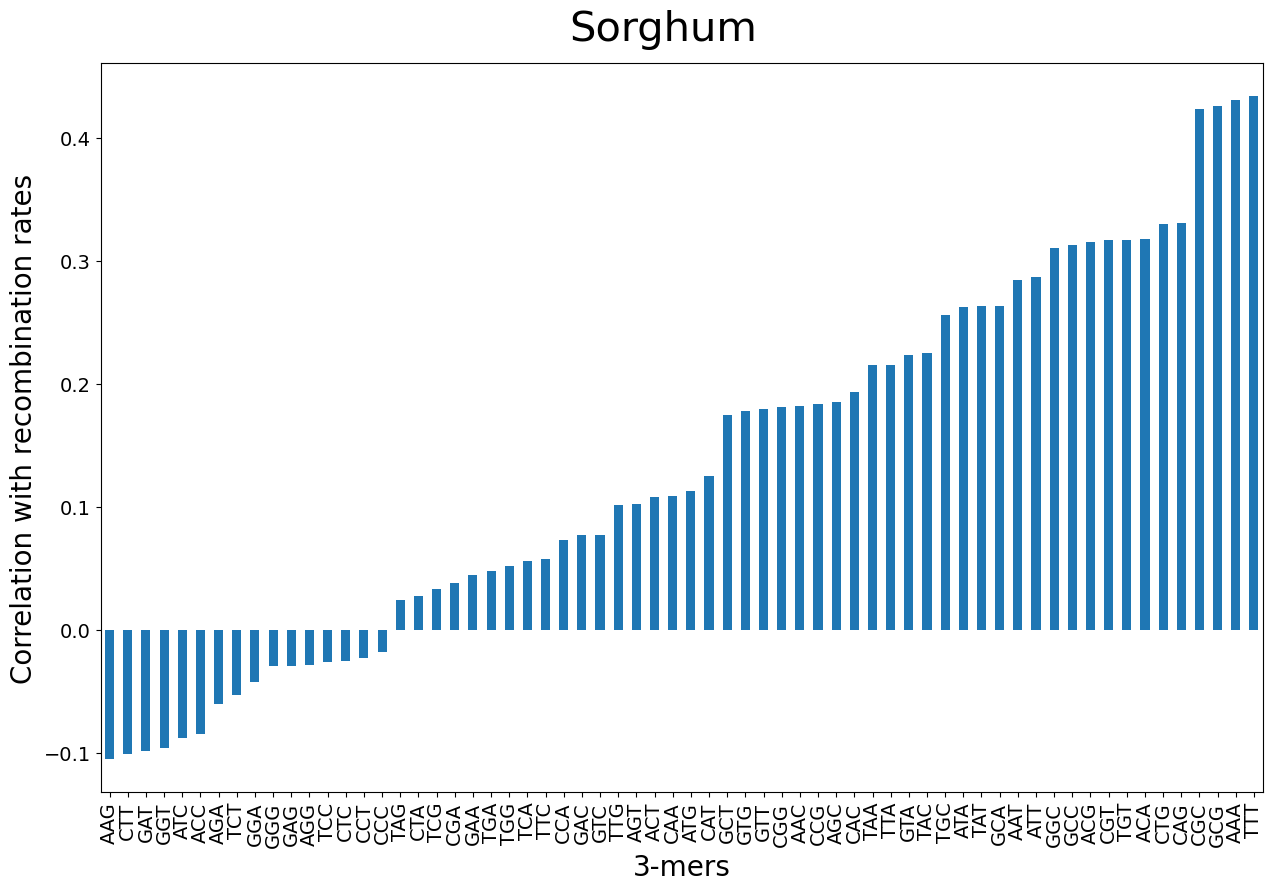

In [20]:
df_stats = df.drop(['chromosome','window_start','window_end','rec'],  axis=1)
df_corr = df_stats.corr()
df_corr = df_corr.iloc[:-1, :]

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df_corr['srec'].sort_values(ascending = True).plot(kind = 'bar')
ax.set_xlabel('3-mers', fontsize=20)
ax.set_ylabel('Correlation with recombination rates', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.suptitle('Sorghum', fontsize=30)
plt.subplots_adjust(top=0.92)

plt.show()

### Model training with all data

In [21]:
X = df.drop(['chromosome','window_start','window_end','rec','srec'],axis=1)
y = df.srec

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

model =  LinearRegression().fit(X_train, y_train)
predict = model.predict(X_test)

### Linear regression coefficients

In [22]:
coefficients = np.around(model.coef_, 4)
intercept = model.intercept_
table_coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': coefficients})
table_coefficients = pd.concat([table_coefficients, pd.DataFrame({'Variable': ['Intercept'], 'Coefficient': [intercept]})], ignore_index=True)
table_coefficients = table_coefficients.transpose()
table_coefficients.columns = table_coefficients.iloc[0]
table_coefficients = table_coefficients.iloc[1:]

sorghum_lm = table_coefficients
sorghum_lm.head()

Variable,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,Intercept
Coefficient,0.0002,0.0005,0.0034,-0.0027,-0.0121,-0.0054,-0.0067,0.0038,-0.0062,-0.0118,...,-0.0047,-0.0019,-0.0073,0.0109,-0.008,-0.0014,0.0168,0.0067,0.0001,-0.001544


In [23]:
sorghum_lm.to_csv('./sorghum_3mers_linear_coefficients.csv', index=False) # To save the coefficients in a csv file

### Evaluation of Shap values

PermutationExplainer explainer: 6450it [02:44, 37.24it/s]                                                              


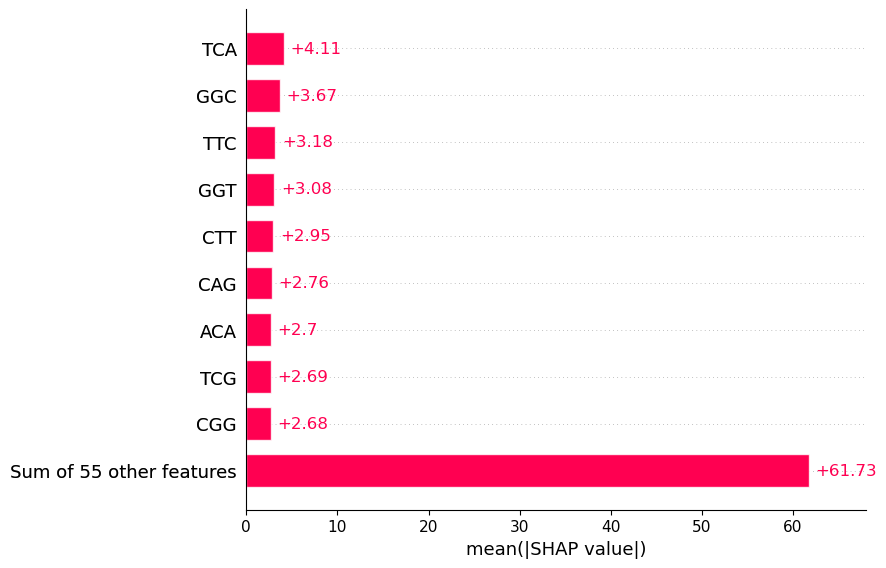

In [24]:
explainer = shap.Explainer(model.predict, X)
shap_values = explainer(X)
shap.plots.bar(shap_values)